# This notebook is for loading and analyzing the dataset.

We will be loading public amazon pricing dataset from Huggingface and pre-processing them using `items.py` and `loaders.py`
The final data will then put into Hugging face Dataset and uploaded to Huggingface Hub.

In [7]:
from datasets import load_dataset, Dataset, DatasetDict
from langchain_openai import ChatOpenAI
from langchain_anthropic import ChatAnthropic

# Update the working directory to the project root, subce juypyter notebook is not treated as a module
import sys
import os
# Add the project root to sys.path
project_root = os.path.abspath("..")  # Move one level up to the project root
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from collections import Counter, defaultdict
from utils.items import Item
from utils.loaders import ItemLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
import dotenv
import random

%matplotlib inline
dotenv.load_dotenv()

True

In [9]:
openai_llm = ChatOpenAI(model="gpt-4o-mini")
anthropic_llm = ChatAnthropic(model="claude-3-sonnet-20240229")

In [5]:
hf_token=os.getenv("HF_TOKEN")

## 1. Loading dataset

Try loading a single Amazon Appliances datset

In [9]:
# Load Amazon appliaces dataset
items = ItemLoader("Appliances").load(workers=4)

Loading dataset Appliances


100%|██████████| 95/95 [00:21<00:00,  4.50it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins


In [17]:
print(items[0].prompt)

How much does this cost to the nearest dollar?

Rack Roller and stud assembly Kit (4 Pack) by AMI PARTS Replaces
PARTS NUMBER The dishwasher top rack wheels and stud assembly Kit （4 pcs） SCOPE OF APPLICATION The dishwasher works with most top name brands,If you are not sure if part is correct, ask us in Customer questions & answers section or visiting the AMI PARTS storefront.We’re happy to help ensure you select the correct part for your Rack Roller and stud REPLACES PART FIXES SYMPTOMS Door won’t close | Not cleaning dishes properly | Noisy | Door latch failure QUALITY WARRANTY The replacement part is made from durable high quality material and well-tested by manufacturer.For any reason you’re not satisfied,you can ask for a replacement or full refund Brand Name AMI PARTS, Model

Price is $9.00


### 1.2 Load more datasets from different categories

In [20]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Appliances",
]

The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [21]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load(workers=8))

Loading dataset Automotive


100%|██████████| 2004/2004 [08:03<00:00,  4.14it/s]


Completed Automotive with 911,688 datapoints in 9.7 mins
Loading dataset Electronics


100%|██████████| 1611/1611 [04:53<00:00,  5.48it/s]


Completed Electronics with 443,473 datapoints in 5.1 mins
Loading dataset Office_Products


100%|██████████| 711/711 [02:28<00:00,  4.80it/s]


Completed Office_Products with 240,394 datapoints in 2.6 mins
Loading dataset Appliances


100%|██████████| 95/95 [00:20<00:00,  4.68it/s]


Completed Appliances with 28,625 datapoints in 0.4 mins


### 1.3 Visualize the datasets

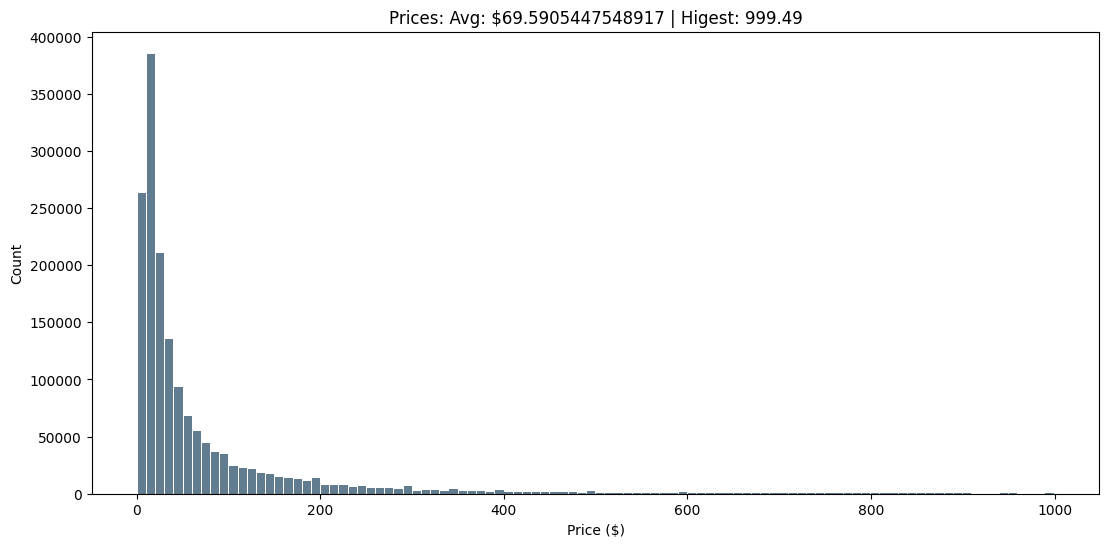

In [25]:
prices = [item.price for item in items]

# Plot graph
plt.figure(figsize=(13, 6))
plt.title(f"Prices: Avg: ${sum(prices)/len(prices)} | Higest: {max(prices)}")
plt.hist(prices, bins=100, rwidth=0.9, color='#607c8e')
plt.xlabel(f"Price ($)")
plt.ylabel("Count")
plt.show()

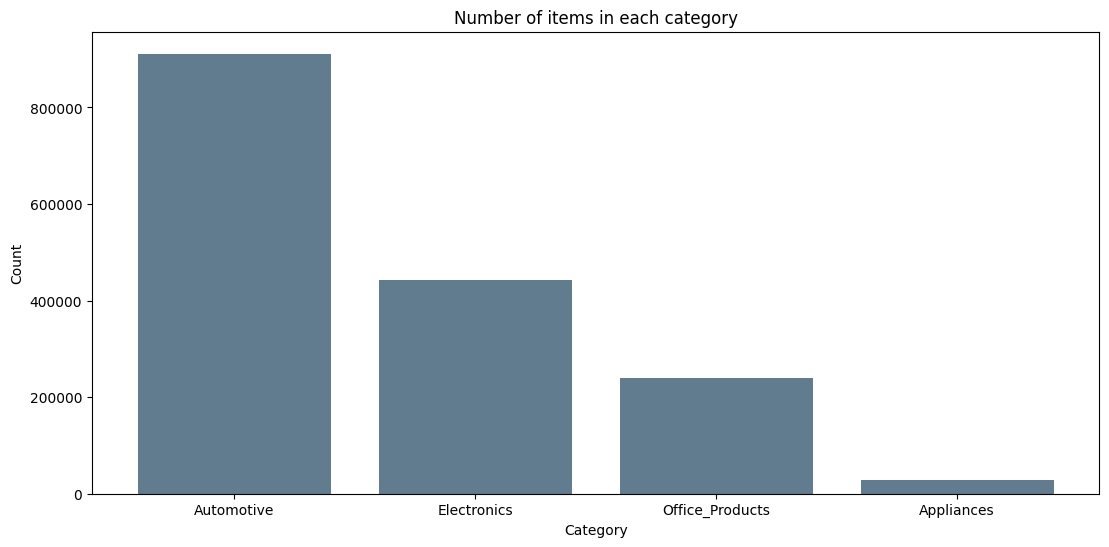

In [27]:
cotegory_counts = Counter([item.category for item in items])

# Visualize how many items in each category
plt.figure(figsize=(13,6))
plt.title("Number of items in each category")
plt.bar(cotegory_counts.keys(), cotegory_counts.values(), color='#607c8e')
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


### 1.4 Balance the dataset for fine tuning

We don't want our data to be too imbalanced and skwewed towards a single category.
Inb this case we want fewer automative items.

In [35]:
# group the item price as key and items as list for each price
slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

print(len(slots[0]))

6


In [47]:
# Create a balanced dataset

import numpy as np
import random

np.random.seed(42)
random.seed(42)
sample = []
for i in range(0, 1000):
    slot = slots[i]
    if i >= 240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)
        
print(f"There are {len(sample):,} items in the balanced dataset")

There are 352,695 items in the balanced dataset


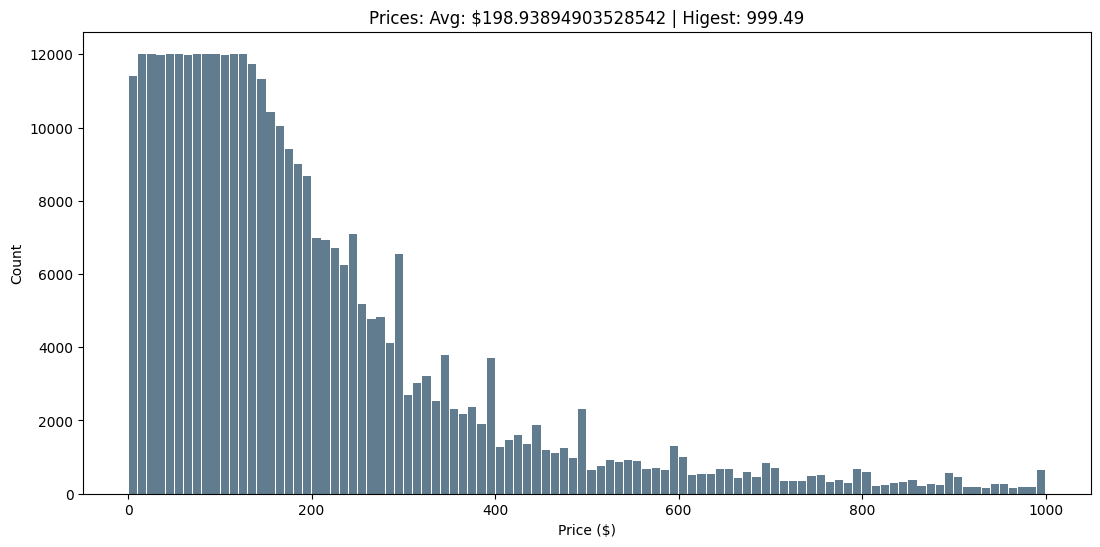

In [49]:
# Look at the distribution of our sample dataset
sample_prices = [item.price for item in sample]

# Plot graph
plt.figure(figsize=(13, 6))
plt.title(f"Prices: Avg: ${sum(sample_prices)/len(sample_prices)} | Higest: {max(sample_prices)}")
plt.hist(sample_prices, bins=100, rwidth=0.9, color='#607c8e')
plt.xlabel(f"Price ($)")
plt.ylabel("Count")
plt.show()

## 2. Data Curation

Prepare and finalize the dataset to be uploaded on Huggingface

In [63]:
# Function to inspect individual sample
def show_item(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(f"Prompt: {prompt}")
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode([tokens[-10:]]))

In [62]:
show_item(sample[1000])

Prompt: How much does this cost to the nearest dollar?

Chase Grace Studio Push Yourself Weightlifting Free Weights Cardio Vinyl Decal Sticker|Black|Cars Trucks Vans SUV Laptops Wall X 2.5
Brand cakuuma, Color Black, Room Type Bedroom, Theme Automobile, Pieces 1, Age Range (Description) Adult, Reusability Single Use, Unit Count 1.0 Count, Finish Type Powder Coated, League ncaa, Dimensions 5.8 x 5.6 x 0.3 inches, Weight 0.634 ounces, model number Rank Computers & Accessories 40621, Sports Fan Computer Accessories 587, Laptop Skins & Decals 12427, Is Discontinued No, Available January 16, 2018, Surface Recommendation Wall, Shape Irregular, Installation Type Self

Price is $2.00
[40245, 4078, 10323, 271, 7117, 374, 400, 17, 13, 410]
[' Installation Type Self\n\nPrice is $2.00']


### 2. Breakdown data into training and testing sets

In [66]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train, test = train_test_split(sample, test_size=0.2, random_state=42)

print(f"Size of training dataset: {len(train):,} | Size of test dataset: {len(test):,}")

Size of training dataset: 282,156 | Size of test dataset: 70,539


In [72]:
# Check the data
print(train[0].prompt)
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

AT-A-GLANCE Daily Appointment Book 2015, 4.88 x 8 Inch Page Size, Black
Around-the-clock planning, 24 hours a day, 7 days a week for the full year. Includes military and standard times with one day per page and hourly appointments, 12 p.m., including weekends. 12 months of planning power, January–December; 4.88 x 8 inch page size; 5.81 x 8.31 x.38 inches overall; Julian dates. One day per page; notes space; past, current and two future months reference. Printed on quality recycled paper with 30% post-consumer waste; black simulated leather wirebound cover. Made in the U.S.A. Get around-the-clock planning with this

Price is $31.00
How much does this cost to the nearest dollar?

Aukilus LCD Display Touch Screen Digitizer Assembly for iPad Mini 4 A1538 A1550 7.9 inch (Black)
Aukilus LCD Display Touch Screen Digitizer Assembly For iPad Mini 4 A1538 A1550 7.9 inch Aukilus LCD Display Touch Screen Digitizer AsseAukilus LCD Display Touch Screen

In [74]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

# Create Dataset from the lists
train_dataset = Dataset.from_dict({"prompt": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"prompt": test_prompts, "price": test_prices})

dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset,
})

To train the LLM model, we just need the training prompt, test prompt and the price of the items

## 3. Upload dataset to Huggingface



In [75]:
DATASET_NAME = 'cshyang/amazon-pricer-data'
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards: 100%|██████████| 1/1 [00:03<00:00,  3.17s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/cshyang/amazon-pricer-data/commit/a2ad9744016c2241eb7c40229c509faf4a651a5c', commit_message='Upload dataset', commit_description='', oid='a2ad9744016c2241eb7c40229c509faf4a651a5c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/cshyang/amazon-pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='cshyang/amazon-pricer-data'), pr_revision=None, pr_num=None)

### 3.1 Let's pickle the training and test dataset so we don't have to load the dataset next time!

In [77]:
import os
import pickle

# Define the folder path
folder_path = 'data'

# Create the folder if it doesn't exist
os.makedirs(folder_path, exist_ok=True)
with open(os.path.join(folder_path, 'train.pkl'), 'wb') as f:
    pickle.dump(train, f)
    
with open(os.path.join(folder_path, 'test.pkl'), 'wb') as f:
    pickle.dump(test, f)